In [1]:
from typing import Tuple, List
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.utils import class_weight
from constants import *
import datetime

In [2]:
x_training = np.load(os.path.join(TRAINING_PATH, "class", "features.npy"), allow_pickle=True)
x_training = np.array([x_training[i].T for i in range(x_training.shape[0])])[-800:]
y_training = np.load(os.path.join(TRAINING_PATH, "class", "labels.npy"), allow_pickle=True)[-800:]
# y_training = np.array([-1 if y<0 else 0 if y==0 else 1 for y in y_training-2])+1

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_training), y=y_training)

# Tune the class weights to improve the model
class_weights[0]=1.7
class_weights[1]=1.4
class_weights[2]=0.1
class_weights[3]=1.6
class_weights[4]=1.7
class_weights = tf.cast(tf.constant(class_weights), "float32") # convert the class weights to a tensor

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

INPUT_DIM = x_training.shape[1:]

x_training = tf.convert_to_tensor(x_training.astype('float32'))
y_training = tf.convert_to_tensor(y_training.astype('int32'))


[1.40350877 1.75824176 0.47619048 1.24031008 1.23076923]
Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [3]:
x_test = np.load(os.path.join(TEST_PATH, "class", "features.npy"), allow_pickle=True)
x_test = np.array([x_test[i].T for i in range(x_test.shape[0])])
y_test = np.load(os.path.join(TEST_PATH, "class", "labels.npy"), allow_pickle=True)
# y_test = np.array([-1 if y<0 else 0 if y==0 else 1 for y in y_test-2])+1

INPUT_DIM = x_test.shape[1:]

In [4]:
x_full = np.concatenate((x_training, x_test)) # concatenate the training and test features
y_full = np.concatenate((y_training, y_test)) # concatenate the training and test labels
x_train_n_inst = int(np.ceil(x_full.shape[0]*0.8)) # calculate the number of training instances

x_training = x_full[:x_train_n_inst] # set the training features
y_training = y_full[:x_train_n_inst] # set the training labels

x_test = x_full[x_train_n_inst:]
y_test = y_full[x_train_n_inst:]

INPUT_DIM = x_training.shape[1:]

# Convert the data to tensors
x_training = tf.convert_to_tensor(x_training.astype('float32'))
y_training = tf.convert_to_tensor(y_training.astype('int32'))

x_test = tf.convert_to_tensor(x_test.astype('float32'))
y_test = tf.convert_to_tensor(y_test.astype('int32'))

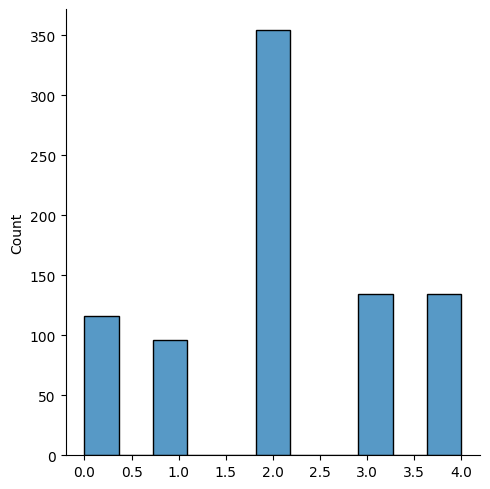

In [5]:
# Visualize the distribution of the labels
import seaborn as sns

sns.displot(y_training)

In [8]:
def weightedLoss(weights=tf.constant([1,1,1,1,1])):

    """Create a weighted loss function."""

    def innerLoss(true, pred):
        w = tf.gather(weights, true) # get the weights for the true labels

        loss = tf.keras.backend.sparse_categorical_crossentropy(true, pred) # calculate the loss
        loss = w * loss # apply the weights to the loss

        return loss

    return innerLoss

In [10]:
lr_scheduler_plt = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001) # define the learning rate scheduler
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # define the early stopping callback

In [67]:

def create_mlp_model(input_shape:Tuple[int, int], 
                     layer_number:int, 
                     neuron_number:List[int], 
                     activation:str|None="relu",
                     loss:str|None = "mae",
                     optimizer:str|None="adam") -> tf.keras.Model:

    """Creates a simple MLP regression model with 6-layers."""

    layers = [tf.keras.layers.Dense(neuron_number[i], activation=activation) for i in range(layer_number)] # create the hidden layers
    layers.insert(0, tf.keras.layers.InputLayer(input_shape=input_shape)) # add the input layer
    layers.insert(1, tf.keras.layers.Flatten()) # add the flatten layer
    layers.append(tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation="softmax")) # add the output layer

    model = tf.keras.Sequential(layers) # create the model
    model.compile(
        loss=weightedLoss(class_weights), # use the weighted loss function
        optimizer = tf.keras.optimizers.legacy.Adadelta(learning_rate=0.001, epsilon=1e-3, rho=0.95), # use the Adadelta optimizer
        metrics=["acc"] # use the accuracy metric
    )

    return model

In [109]:
model = create_mlp_model(INPUT_DIM, 5, [112, 116, 27, 123, 50], activation="tanh") # create the model

mae


In [110]:
## model training 
history = model.fit(x_training, 
                    y_training, 
                    epochs=100, 
                    batch_size=64, 
                    verbose=1, 
                    validation_split=0.10, 
                    callbacks=[lr_scheduler_plt]
                    )

Epoch 1/100
12/12 [==============================] - 1s 48ms/step - loss: 1.6144 - acc: 0.2120 - val_loss: 1.2242 - val_acc: 0.3095 - lr: 0.0010
Epoch 2/100
12/12 [==============================] - 0s 12ms/step - loss: 1.5782 - acc: 0.2867 - val_loss: 1.2038 - val_acc: 0.3690 - lr: 0.0010
Epoch 3/100
12/12 [==============================] - 0s 17ms/step - loss: 1.5518 - acc: 0.3440 - val_loss: 1.1888 - val_acc: 0.3690 - lr: 0.0010
Epoch 4/100
12/12 [==============================] - 0s 13ms/step - loss: 1.5387 - acc: 0.3560 - val_loss: 1.1785 - val_acc: 0.3929 - lr: 0.0010
Epoch 5/100
12/12 [==============================] - 0s 11ms/step - loss: 1.5290 - acc: 0.3680 - val_loss: 1.1711 - val_acc: 0.3929 - lr: 0.0010
Epoch 6/100
12/12 [==============================] - 0s 12ms/step - loss: 1.5203 - acc: 0.3760 - val_loss: 1.1650 - val_acc: 0.4048 - lr: 0.0010
Epoch 7/100
12/12 [==============================] - 0s 13ms/step - loss: 1.5141 - acc: 0.3747 - val_loss: 1.1603 - val_acc: 0.404

In [111]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 900)               0         
                                                                 
 dense_36 (Dense)            (None, 112)               100912    
                                                                 
 dense_37 (Dense)            (None, 116)               13108     
                                                                 
 dense_38 (Dense)            (None, 27)                3159      
                                                                 
 dense_39 (Dense)            (None, 123)               3444      
                                                                 
 dense_40 (Dense)            (None, 50)                6200      
                                                                 
 dense_41 (Dense)            (None, 5)                

In [112]:
accuracy = history.history["acc"] # get the training accuracy
val_accuracy = history.history["val_acc"] # get the validation accuracy

loss = history.history["loss"] # get the training loss
val_loss = history.history["val_loss"] # get the validation loss

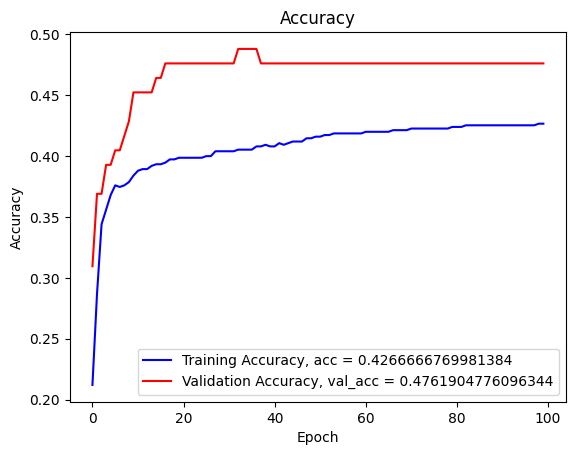

In [160]:
# Plot the accuracy 
plt.plot(range(len(accuracy)), accuracy, "b", label = f"Training Accuracy, acc = {accuracy[-1]}")
plt.plot(range(len(accuracy)), val_accuracy, "-r", label = f"Validation Accuracy, val_acc = {val_accuracy[-1]}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

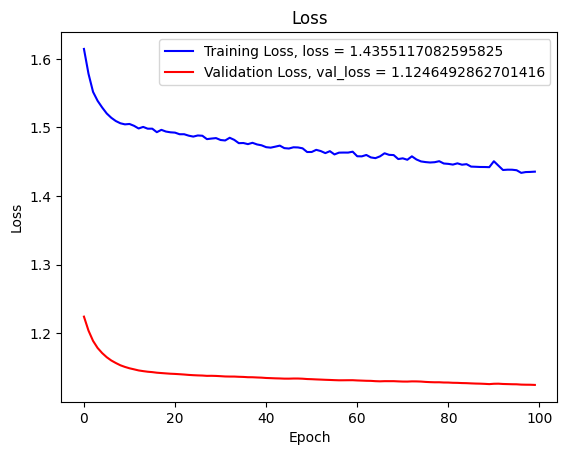

In [161]:
# Plot the loss
plt.plot(range(len(accuracy)), loss, "b", label = f"Training Loss, loss = {loss[-1]}")
plt.plot(range(len(accuracy)), val_loss, "-r", label = f"Validation Loss, val_loss = {val_loss[-1]}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")
plt.show()

In [116]:
model.evaluate(x_test, y_test) # evaluate the model on the test set

7/7 [==============================] - 0s 15ms/step - loss: 1.1615 - acc: 0.5000


[1.1614940166473389, 0.5]

In [117]:
from sklearn.metrics import classification_report, confusion_matrix

In [118]:
#Predict
y_prediction = model.predict(x_test)

y_prediction = np.argmax (y_prediction, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(classification_report(y_test, y_prediction))

7/7 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.17      0.11      0.13        18
           1       0.50      0.07      0.13        27
           2       0.54      0.90      0.67       109
           3       0.14      0.05      0.07        22
           4       0.33      0.03      0.06        32

    accuracy                           0.50       208
   macro avg       0.34      0.23      0.21       208
weighted avg       0.43      0.50      0.40       208



<Axes: >

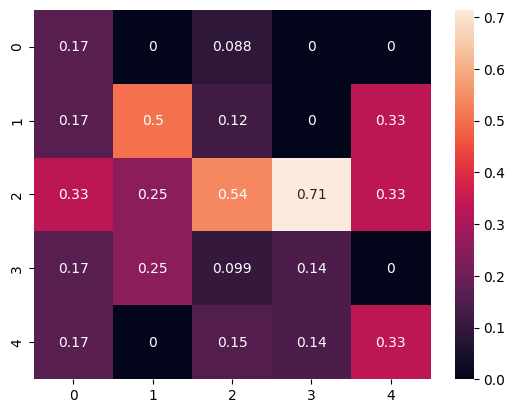

In [119]:
sns.heatmap(result, annot=True) # plot the confusion matrix

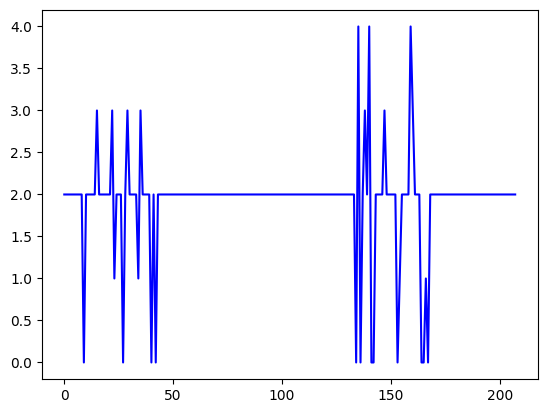

In [120]:
plt.plot(range(len(y_prediction)), y_prediction[:], "-b", label = f"Predicted") # plot the predicted labels

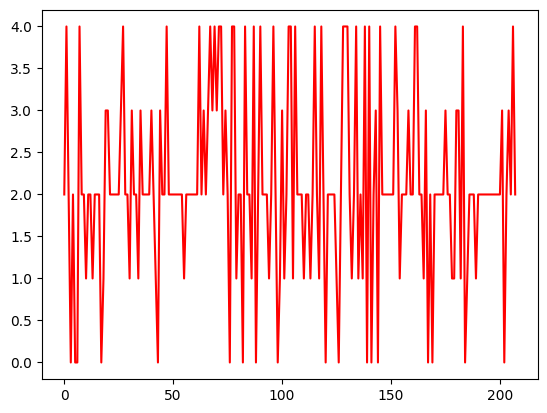

In [121]:
plt.plot(range(len(y_prediction)), y_test[:], "-r", label = f"Actual") # plot the actual labels

In [122]:
right_idx = np.where(y_prediction == y_test)[0]
idxs = range(len(y_prediction))
not_right_idx = [i for i in idxs if i not in right_idx]
right = np.zeros_like(y_prediction)
right[right_idx] = y_prediction[right_idx]
right[not_right_idx] = 5

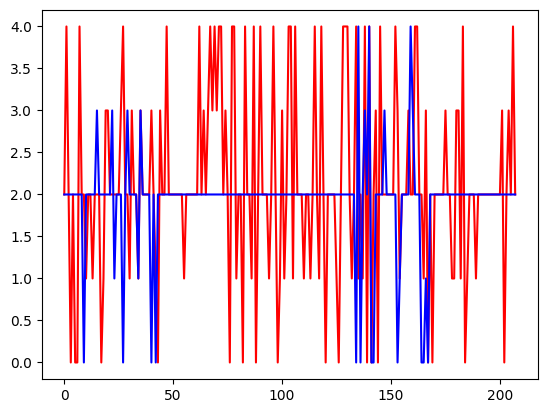

In [123]:
plt.plot(range(len(y_prediction)), y_test[:], "r", label = f"Actual")
plt.plot(range(len(y_prediction)), y_prediction[:], "b", label = f"Predicted")
plt.show()

In [124]:
def foo(y_test, y_prediction):
    y_test = y_test-2
    y_test = np.array([-1 if i<0 else 0 if i==0 else 1 for i in y_test])
    y_prediction = y_prediction-2
    y_prediction = np.array([-1 if i<0 else 0 if i==0 else 1 for i in y_prediction])

    return np.where(y_test == y_prediction)[0].shape[0]/y_test.shape[0]

In [125]:
foo(y_test, y_prediction)

0.5144230769230769

In [153]:
model.save(os.path.join("models/mlp/class", f"{datetime.datetime.now().strftime('%Y-%m-%d-%H')}.h5")) # save the model

In [1513]:
config = model.get_config() # get the model configuration

In [150]:
import json
def weights_to_json(weights:np.ndarray[np.ndarray]):

    """Converts the weights to a json file."""
    
    weight_dict = {}
    for i, w in enumerate(weights):
        
        if i%2==0 and i>0:
            idx = int((i-2)/2)
            weight_dict[f"layer_{idx}"] = {}
            weight_dict[f"layer_{idx}"]["n_rows"] = w.shape[0]
            weight_dict[f"layer_{idx}"]["n_columns"] = w.shape[1]
            weight_dict[f"layer_{idx}"]["weights"] = w.flatten().tolist()
            weight_dict[f"layer_{idx}"]["bias"] = weights[i-1].flatten().tolist()

    print(weight_dict)
    json.dump(weight_dict, open(f"models/mlp/class/weights/{datetime.datetime.now().strftime('%Y-%m-%d-%H')}.json", "w"))


In [151]:
weights_list=model.get_weights() # get the model weights

In [152]:
weights_to_json(weights_list) # save the weights to a json file

12
0
(112, 116)
(112,)
{'layer_0': {'n_rows': 112, 'n_columns': 116, 'weights': [-0.058103229850530624, 0.05447281152009964, -0.15446454286575317, 0.13109076023101807, -0.004203818738460541, 0.10124184936285019, -0.05525722727179527, 0.08937253057956696, 0.019791219383478165, -0.1391816884279251, 0.14758099615573883, -0.04344584792852402, 0.02258247882127762, 0.08036156743764877, 0.03479335457086563, -0.005220319610089064, -0.11343555152416229, 0.12352657318115234, -0.024419907480478287, 0.029877837747335434, 0.12723518908023834, -0.0334017239511013, 0.022374765947461128, 0.0098120654001832, -0.034750912338495255, 0.0014730192488059402, 0.07861977070569992, -0.04317113384604454, -0.07805292308330536, -0.07242128998041153, 0.120907723903656, 0.060720305889844894, 0.008968079462647438, -0.04122433811426163, -0.029060689732432365, -0.08828411251306534, 0.14450260996818542, 0.05403108522295952, 0.12231415510177612, -0.11242875456809998, -0.07480905205011368, 0.0761278048157692, 0.054269317

In [157]:
model_1 = tf.keras.models.load_model(os.path.join("models/mlp/class", f"{datetime.datetime.now().strftime('%Y-%m-%d-%H')}.h5"), compile=False) # load the model

# Grid Search

In [162]:
import keras_tuner as kt
from pathlib import Path

from typing import Tuple, List
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.utils import class_weight
from constants import *

In [163]:
x_training = np.load(os.path.join(TRAINING_PATH, "class", "features.npy"), allow_pickle=True)
x_training = np.array([x_training[i].T for i in range(x_training.shape[0])])[-800:]
y_training = np.load(os.path.join(TRAINING_PATH, "class", "labels.npy"), allow_pickle=True)[-800:]

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_training), y=y_training)*2
class_weights = tf.cast(tf.constant(class_weights), "float32")

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

INPUT_DIM = x_training.shape[1:]

x_training = tf.convert_to_tensor(x_training.astype('float32'))
y_training = tf.convert_to_tensor(y_training.astype('int32'))

In [164]:
x_test = np.load(os.path.join(TEST_PATH, "class", "features.npy"), allow_pickle=True)
x_test = np.array([x_test[i].T for i in range(x_test.shape[0])])
y_test = np.load(os.path.join(TEST_PATH, "class", "labels.npy"), allow_pickle=True)

INPUT_DIM = x_test.shape[1:]

In [165]:
x_full = np.concatenate((x_training, x_test))
y_full = np.concatenate((y_training, y_test))
x_train_n_inst = int(np.ceil(x_full.shape[0]*0.8))

x_training = x_full[:x_train_n_inst]
y_training = y_full[:x_train_n_inst]

x_test = x_full[x_train_n_inst:]
y_test = y_full[x_train_n_inst:]

INPUT_DIM = x_training.shape[1:]

val_n = int(len(x_training)*0.1)

x_training = x_training[:-val_n]
y_training = y_training[:-val_n]

x_val = x_training[-val_n:]
y_val = y_training[-val_n:]

print(f"Shape of training data: {x_training.shape}")
print(f"Shape of training labels: {y_training.shape}")
print(f"Shape of validation data: {x_val.shape}")
print(f"Shape of validation labels: {y_val.shape}")
print(f"Shape of test data: {x_test.shape}")
print(f"Shape of test labels: {y_test.shape}")

x_training = tf.convert_to_tensor(x_training.astype('float32'))
y_training = tf.convert_to_tensor(y_training.astype('int32'))

x_test = tf.convert_to_tensor(x_test.astype('float32'))
y_test = tf.convert_to_tensor(y_test.astype('int32'))

x_val = tf.convert_to_tensor(x_val.astype('float32'))
y_val = tf.convert_to_tensor(y_val.astype('int32'))

Shape of training data: (751, 25, 36)
Shape of training labels: (751,)
Shape of validation data: (83, 25, 36)
Shape of validation labels: (83,)
Shape of test data: (208, 25, 36)
Shape of test labels: (208,)


In [166]:
def weightedLoss(weights=tf.constant([1,1,1,1,1])):
    @tf.function(reduce_retracing=True)
    def innerLoss(true, pred):
        w = tf.gather(weights, true) #(batch, labels, 1)

        loss = tf.keras.backend.sparse_categorical_crossentropy(true, pred) #(batch, labels)
        loss = w * loss

        return loss

    return innerLoss

In [167]:
@tf.function(reduce_retracing=True)
def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1))) # true positives
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1))) # predicted positives
    if tf.cast(predicted_positives, 'float32')<0.001:
        predicted_positives = tf.convert_to_tensor([1000000.00]) # to avoid division by zero
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon()) # calculate precision
    return precision

@tf.function(reduce_retracing=True)
def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1))) # true positives
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1))) # possible positives
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon()) # calculate recall
    return recall

In [168]:
def build_model(hp):

    """Build the model with hyperparameters for the hyperparameter tuning"""

    n_hidden = hp.Int('n_hidden', min_value=1, max_value=5, default=2) # Number of hidden layers
    n_neurons_1 = hp.Int('n_neurons_1', min_value=16, max_value=128, default=32) # Number of neurons in the first hidden layer
    n_neurons_2 = hp.Int('n_neurons_2', min_value=16, max_value=128, default=32) # Number of neurons in the second hidden layer
    n_neurons_3 = hp.Int('n_neurons_3', min_value=16, max_value=128, default=32) # Number of neurons in the third hidden layer
    n_neurons_4 = hp.Int('n_neurons_4', min_value=16, max_value=128, default=32) # Number of neurons in the fourth hidden layer
    n_neurons_5 = hp.Int('n_neurons_5', min_value=16, max_value=128, default=32) # Number of neurons in the fifth hidden layer
    n_neurons = [n_neurons_1, n_neurons_2, n_neurons_3, n_neurons_4, n_neurons_5] # List of neurons in each hidden layer
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log') # Learning rate
    optimizer = hp.Choice('optimizer', ['adam', 'adagrad', 'adadelta']) # Optimizer
    weighted = hp.Boolean('weighted', default=True) # Weighted loss
    epsilon = hp.Float('epsilon', min_value=1e-10, max_value=1e-2, sampling='log') # Epsilon for optimizer
    rho = hp.Float('rho', min_value=0.7, max_value=0.98, sampling='log') # Rho for optimizer

    # Choose the optimizer
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, epsilon=epsilon)
    elif optimizer == 'adagrad':
        optimizer = tf.keras.optimizers.legacy.Adagrad(learning_rate=learning_rate, epsilon=epsilon)
    elif optimizer == 'adadelta':
        optimizer = tf.keras.optimizers.legacy.Adadelta(learning_rate=learning_rate, epsilon=epsilon, rho=rho)
        
    # Choose the loss function
    if weighted:
        loss=weightedLoss(class_weights)
    else:
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

    model = tf.keras.Sequential() # Initialize the model
    model.add(tf.keras.layers.InputLayer(input_shape=INPUT_DIM)) # Input layer
    model.add(tf.keras.layers.Flatten()) # Flatten the input
    for i in range(n_hidden): # Add the hidden layers
        model.add(tf.keras.layers.Dense(n_neurons[i], activation='tanh'))
    model.add(tf.keras.layers.Dense(5, activation='softmax')) # Output layer

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['acc', precision, recall])
    
    return model

In [169]:
class ClassHyperModel(kt.HyperModel):

    """Class for the hyperparameter tuning"""

    def build(self, hp):
        return build_model(hp) # Build the model
    
    def fit(self, hp, model, X, y, **kwargs):
        return model.fit(X, y, **kwargs) # Fit the model

In [170]:
# Initialize the hyperband tuner
hyperband_tuner = kt.Hyperband(ClassHyperModel(),
                               objective=kt.Objective('val_acc', direction='max'), # Objective as validation accuracy to maximize
                               seed=42, # Set the random seed
                               max_epochs=50, # Maximum number of epochs
                               hyperband_iterations=2, # Number of hyperband iterations
                               factor=3, # Reduction factor for the number of epochs and number of models
                               overwrite=True, # Overwrite the results of the previous tuning
                               directory = "models", # Directory to save the models
                               project_name = "trading_bot") 

In [171]:
root_logdir = Path(hyperband_tuner.project_dir)/"tensorboard" # Directory for tensorboard logs
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir) # Tensorboard callback
lr_scheduler_plt = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001) # Learning rate scheduler
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # Early stopping

# Search for the best hyperparameters
hyperband_tuner.search(x_training, y_training, 
                       validation_data=(x_val, y_val),
                       epochs=50,    
                       callbacks=[tensorboard_cb, lr_scheduler_plt, early_stopping]) 

Trial 74 Complete [00h 07m 44s]
val_acc: 0.9879518151283264

Best val_acc So Far: 1.0
Total elapsed time: 00h 25m 01s

Search: Running Trial #75

Value             |Best Value So Far |Hyperparameter
4                 |4                 |n_hidden
39                |109               |n_neurons_1
76                |123               |n_neurons_2
83                |110               |n_neurons_3
23                |44                |n_neurons_4
99                |78                |n_neurons_5
0.00060861        |0.00070724        |learning_rate
adadelta          |adam              |optimizer
False             |False             |weighted
1.5881e-10        |4.1198e-09        |epsilon
0.84193           |0.72628           |rho
17                |17                |tuner/epochs
0                 |6                 |tuner/initial_epoch
1                 |3                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/17
 4/24 [====>.........................] - ETA: 

KeyboardInterrupt: 

In [ ]:
hyperband_tuner.results_summary(86)

Results summary
Results in models/trading_bot
Showing 86 best trials
Objective(name="val_acc", direction="max")


In [238]:
from sklearn.metrics import classification_report, confusion_matrix

In [239]:
#Predict
y_prediction = best_model.predict(x_test)

y_prediction = np.argmax (y_prediction, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(classification_report(y_test, y_prediction))
print(result)

8/8 [==============================] - 0s 18ms/step
              precision    recall  f1-score   support

           0       0.05      0.05      0.05        20
           1       0.00      0.00      0.00        32
           2       0.52      0.63      0.57       126
           3       0.10      0.12      0.11        26
           4       0.22      0.23      0.22        35

    accuracy                           0.38       239
   macro avg       0.18      0.20      0.19       239
weighted avg       0.32      0.38      0.35       239

[[0.05263158 0.         0.10526316 0.06666667 0.02702703]
 [0.15789474 0.         0.11842105 0.3        0.05405405]
 [0.63157895 1.         0.51973684 0.43333333 0.56756757]
 [0.10526316 0.         0.10526316 0.1        0.13513514]
 [0.05263158 0.         0.15131579 0.1        0.21621622]]


In [172]:
%reload_ext tensorboard
%tensorboard --logdir models/trading_bot/tensorboard --port=9009

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Address already in use
Port 7007 is in use by another program. Either identify and stop that program, or start the server with a different port.